# Visualise attention mechanism

An important part of analysing the data is the attention mechanism, which allows the model to focus on different parts of the input data. Being able to visualise this mechanism is a key aspect of understanding how the network behaves. In this notebook I will
- Load preselected data
- Run the model on the preselected data
- Visualise the attention map on the input data

Due to the size of the network, this image has been saved. Uncomment the code to reproduce.

In [1]:
from libs.network.network import AttU_Net
import pickle
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# uncomment when running the model independently

# # Define paths
# network_path = "data/network_att_map.pth"
# data_path = "data/data_att_map.pkl"

# # load torch input tensor
# with open(data_path, "rb") as f:
#     input_tensor = pickle.load(f)


# load saved data
with open("data/attention_overlay.pkl", "rb") as f:
    data = pickle.load(f)
    input_tensor = data["input_tensor"]
    attention = data["attention"]


## Load network and run output

In [2]:

# network = AttU_Net()
# network.load_state_dict(torch.load(network_path, map_location=torch.device('cpu')))  # Load the trained network weights
# network.eval()

# output, attention_maps = network.getAttenuationMap(input_tensor)


# Visualise attention mechanism

Define function show_attention_overlay which as an argument takes the input data, the attention weights, the slice axis and the slice index. 
For this example I have chosen to slice along the y-direction to properly visualise the sinogram.

In [3]:
def show_attention_overlay(input_tensor, attention, slice_axis=2, slice_idx=0, title="Attention Overlay"):
    """
    Visualize attention over an input slice.

    Args:
        input_tensor: torch.Tensor [1, C, D, H, W]
        attention:    torch.Tensor [1, 1, D', H', W']
        slice_axis:   0=D, 1=H, 2=W (which axis to slice through)
        slice_idx:    index along that axis
    """
    assert input_tensor.ndim == 5 and attention.ndim == 5

    # Resize attention to match input spatial dims
    attn_resized = F.interpolate(attention, size=input_tensor.shape[2:], mode='trilinear', align_corners=False)

    # Select first input channel and remove batch dim
    input_tensor = input_tensor[6, 0].detach().cpu()
    attn_tensor = attn_resized[6, 0].detach().cpu()
    
    # Normalize attention
    attn_tensor = (attn_tensor - attn_tensor.min()) / (attn_tensor.max() - attn_tensor.min() + 1e-8)

    # Choose slice
    if slice_axis == 0:  # Depth
        input_slice = input_tensor[slice_idx, :, :].numpy()
        attn_slice  = attn_tensor[slice_idx, :, :].numpy()
    elif slice_axis == 1:  # Height
        input_slice = input_tensor[:, slice_idx, :].numpy()
        attn_slice  = attn_tensor[:, slice_idx, :].numpy()
    elif slice_axis == 2:  # Width
        input_slice = input_tensor[:, :, slice_idx].numpy()
        attn_slice  = attn_tensor[:, :, slice_idx].numpy()
    else:
        raise ValueError("slice_axis must be 0 (D), 1 (H), or 2 (W)")

    plt.figure(figsize=(10, 4))
    plt.rcParams['axes.labelsize'] = 14

    # Plot overlay
    plt.imshow(input_slice, cmap='gray')
    plt.imshow(attn_slice, cmap='jet', alpha=0.3)
    # make colourbar same height as image
    plt.xlabel('Z')
    plt.ylabel('X')
    plt.colorbar(label=r'$\alpha$', fraction=0.046, pad=0.04)
    plt.show()

## Plot attention map

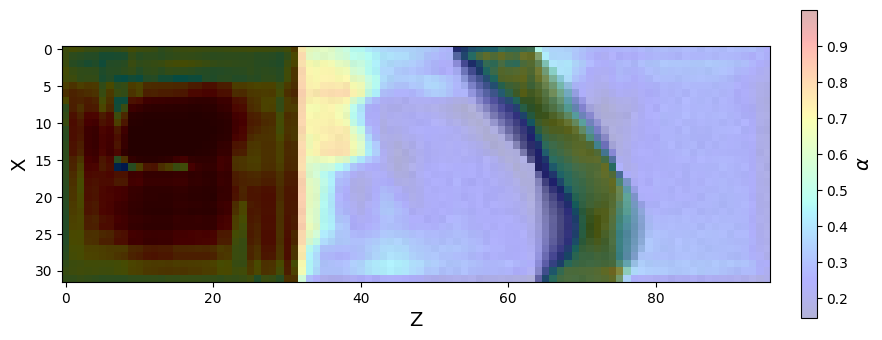

In [4]:
# | label: show_attention_overlay
# attention = attention_maps['att2']
show_attention_overlay(input_tensor, attention, slice_axis=1, slice_idx=41, title="Attention from att4")